In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
import time
import pandas as pd
import traceback

# Set up the WebDriver with additional Chrome options to block ads and pop-ups
def create_driver():
    options = Options()
    options.headless = False  # Change to True to run without the browser window
    options.add_argument("--disable-popup-blocking")  # Disable pop-ups
    options.add_argument("--incognito")  # Use incognito mode to prevent storing cookies
    options.add_argument("--disable-extensions")  # Disable extensions that may interfere
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
    return driver

# List of all NBA teams and the seasons we want to scrape
teams = [
    'ATL', 'BOS', 'BRK', 'CHO', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM',
    'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHI', 'PHO', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS'
]
seasons = ['2022', '2023', '2024']

# Initialize a list to hold all the data
all_data = []

# Loop through all the teams and seasons
for team in teams:
    for season in seasons:
        # Construct the URL for the specific season and team
        team_url = f'https://www.basketball-reference.com/teams/{team}/{season}.html'
        
        # Retry logic for broken sessions
        retries = 3
        while retries > 0:
            try:
                # Create a new WebDriver instance
                driver = create_driver()
                
                # Open the webpage
                driver.get(team_url)
                # Wait for the page to load
                time.sleep(5)  # Adjust sleep time to ensure all elements load properly

                # Print the page title for debugging
                print(f"Page title for {team_url}: {driver.title}")

                # Handle any pop-ups by finding and closing them if they appear
                try:
                    pop_up = driver.find_element(By.XPATH, '//button[contains(@class, "close")]')
                    pop_up.click()
                    time.sleep(1)  # Short delay after closing the pop-up
                except:
                    pass  # If no pop-up is found, continue

                # Find the specific team misc table using its headers
                table = driver.find_elements(By.XPATH, "//table[contains(@id, 'team_misc') or contains(@id, 'all_team_and_opponent')]")[0]

                # Extract the header row (the second row with actual column names)
                headers = table.find_elements(By.XPATH, './/thead//tr[2]/th')

                # Extract the column names and shift the headers to the left by 1
                header_text = [header.text for header in headers][1:11]  # Skip the first (empty) column and only get the first 10 columns

                # Extract the data rows
                rows = table.find_elements(By.XPATH, './/tbody//tr')
                data = []
                for row in rows:
                    columns = row.find_elements(By.TAG_NAME, 'td')
                    column_data = [col.text for col in columns][:10]  # Only keep the first 10 columns
                    data.append(column_data)

                # Add team and season to each row
                final_data = [[team, season] + row for row in data]

                # Append the data for this team and season to the all_data list
                all_data.extend(final_data)

                # Break out of the retry loop once scraping is successful
                break
            except Exception as e:
                print(f"Error encountered while scraping {team} {season}: {e}")
                print(f"Retrying... ({retries} attempts left)")
                retries -= 1
                if retries == 0:
                    print(f"Failed to scrape {team} {season} after multiple retries.")
                    # Optionally, log or save the failure
                    with open("scrape_errors.txt", "a") as log:
                        log.write(f"Failed to scrape {team} {season}: {str(e)}\n")
                else:
                    time.sleep(5)  # Wait before retrying
                # Reinitialize the driver for the next attempt
                driver.quit()

# Convert the data into a pandas DataFrame
df = pd.DataFrame(all_data, columns=['Team', 'Season'] + header_text)

# Print the DataFrame to verify the results
print(df)

# Save the data to a CSV file
df.to_csv('nba_teams_2022_2023_2024_team_misc.csv', index=False)

# Close the WebDriver window at the end
driver.quit()


/var/folders/l5/z0v41dm91r78xv26fsbmjbk80000gn/T/ipykernel_26876/3536447654.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Season'] = df_selected['Season'].astype(str)


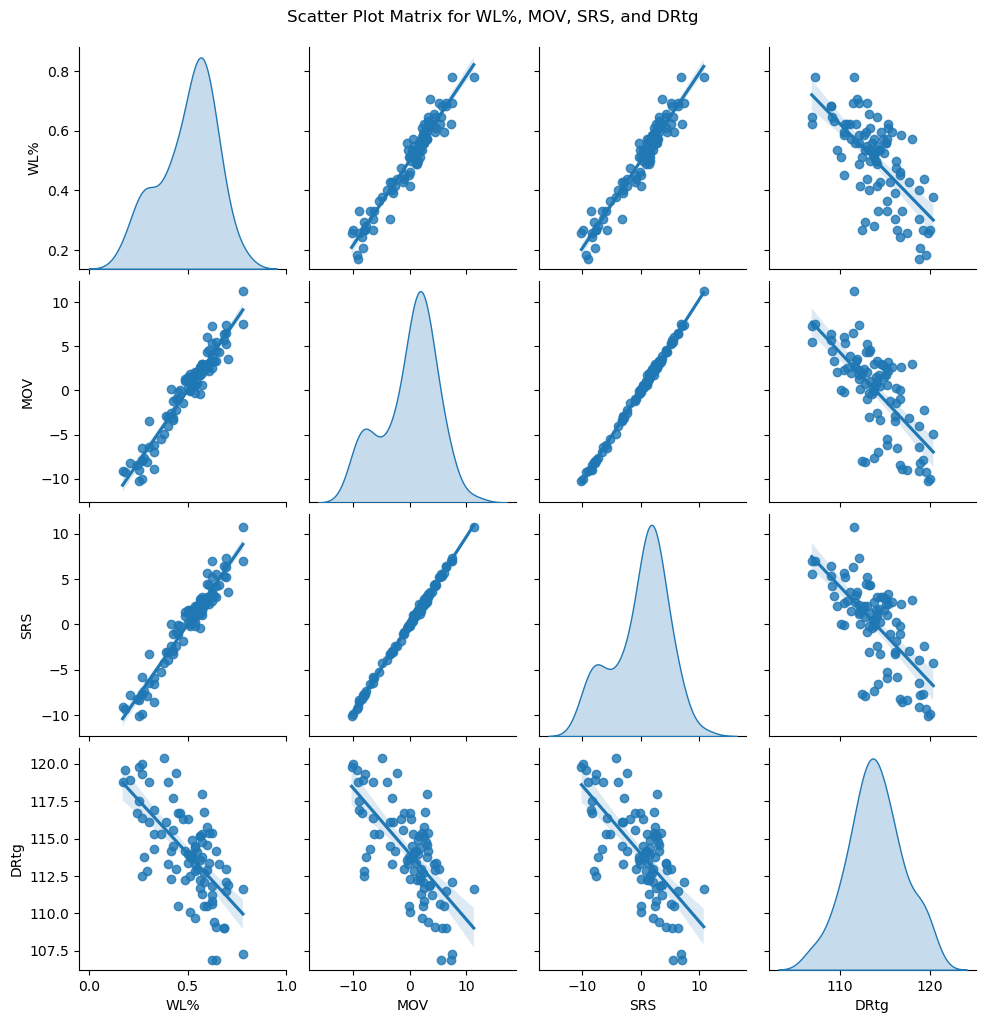

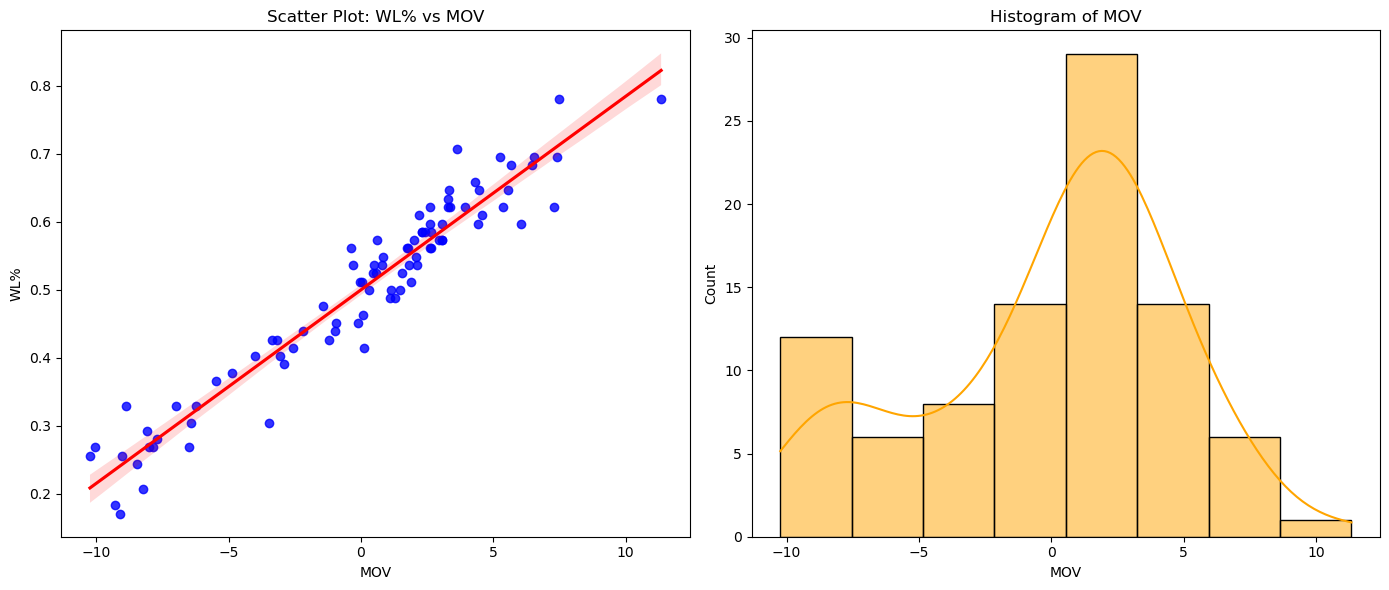

Correlation Matrix:
           WL%       MOV       SRS      DRtg
WL%   1.000000  0.963863  0.963545 -0.670158
MOV   0.963863  1.000000  0.998918 -0.692584
SRS   0.963545  0.998918  1.000000 -0.692252
DRtg -0.670158 -0.692584 -0.692252  1.000000


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data from CSV file
file_path = '/Users/lizvitai/Documents/PythonSports/nba_teams_2022_2023_2024_team_misc.csv'
df = pd.read_csv(file_path)

# Filter out the 'Lg Rank' rows based on the 'Team' column and reset the index
df_cleaned = df[df['Team'] != 'Lg Rank'].reset_index(drop=True)

# Calculate the Win-Loss percentage (WL%) and handle ties (assuming no 'T' column exists in this dataset)
df_cleaned['WL%'] = df_cleaned['W'] / (df_cleaned['W'] + df_cleaned['L'])

# Select relevant columns: MOV (Margin of Victory), SRS (Simple Rating System), DRtg (Defensive Rating)
selected_columns = ['Team', 'Season', 'W', 'L', 'MOV', 'SRS', 'DRtg', 'WL%']
df_selected = df_cleaned[selected_columns]

# Convert the 'Season' column to a string for consistency
df_selected['Season'] = df_selected['Season'].astype(str)

# To filter only the first row for each Team and Season combination
df_first_row_per_season = df_selected.groupby(['Team', 'Season']).first().reset_index()

# Generate the scatter plot matrix with best fit regression lines
sns.pairplot(df_first_row_per_season, vars=['WL%', 'MOV', 'SRS', 'DRtg'], kind='reg', diag_kind='kde')
plt.suptitle('Scatter Plot Matrix for WL%, MOV, SRS, and DRtg', y=1.02)
plt.savefig('/Users/lizvitai/Documents/PythonSports/scatter_plot_matrix.pdf')
plt.show()

# Pick the stat that best predicts WL% based on the scatter plot matrix.
# MOV seems to have the strongest correlation with WL%.

# Create the second figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# First subplot: Scatter plot of WL% vs. MOV with a best fit line
sns.regplot(x='MOV', y='WL%', data=df_first_row_per_season, ax=axs[0], scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
axs[0].set_title('Scatter Plot: WL% vs MOV')

# Second subplot: Histogram of MOV
sns.histplot(df_first_row_per_season['MOV'], kde=True, color='orange', ax=axs[1])
axs[1].set_title('Histogram of MOV')

# Save the figure as a PDF
plt.tight_layout()
plt.savefig('/Users/lizvitai/Documents/PythonSports/mov_vs_wl_and_histogram.pdf')
plt.show()

# Print the correlation matrix
correlation_matrix = df_first_row_per_season[['WL%', 'MOV', 'SRS', 'DRtg']].corr()
print("Correlation Matrix:")
print(correlation_matrix)


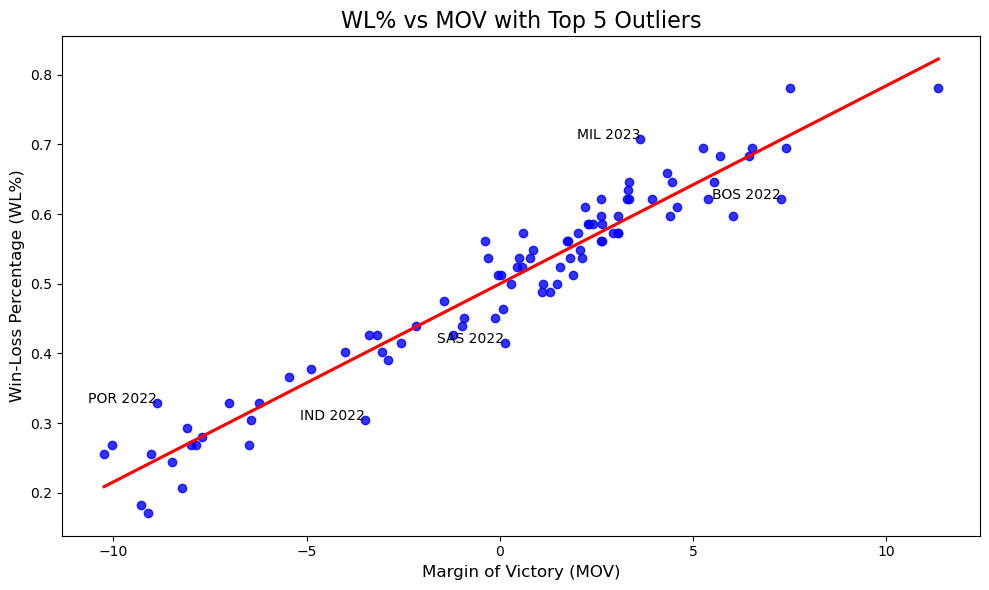

Top 5 outliers:
    Team  Season       WL%   MOV  predicted  residual  abs_residual
98   MIL    2023  0.707317  3.63   0.603319  0.103998      0.103998
66   IND    2022  0.304878 -3.48   0.400981 -0.096103      0.096103
156  SAS    2022  0.414634  0.12   0.503431 -0.088797      0.088797
6    BOS    2022  0.621951  7.28   0.707192 -0.085240      0.085240
144  POR    2022  0.329268 -8.88   0.247307  0.081961      0.081961


In [3]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Read in the data
df_cleaned = pd.read_csv('/Users/lizvitai/Documents/PythonSports/nba_teams_2022_2023_2024_team_misc.csv')

# Remove rows with rankings (second rows for each season), keeping only the first row for each season
df_cleaned = df_cleaned[~df_cleaned.duplicated(subset=['Team', 'Season'], keep='first')]

# Calculate Win-Loss Percentage (WL%)
df_cleaned['WL%'] = df_cleaned['W'] / (df_cleaned['W'] + df_cleaned['L'])

# Select relevant columns for analysis
df_selected = df_cleaned[['Team', 'Season', 'WL%', 'MOV']]

# Prepare data for regression (independent variable is MOV, dependent variable is WL%)
X = df_selected[['MOV']]  # Features (MOV)
y = df_selected['WL%']  # Target (WL%)

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)

# Creating a copy of the selected rows
df_selected = df_cleaned[['Team', 'Season', 'WL%', 'MOV']].copy()

# Calculate predictions, residuals, and absolute residuals
df_selected.loc[:, 'predicted'] = model.predict(X)
df_selected.loc[:, 'residual'] = df_selected['WL%'] - df_selected['predicted']
df_selected.loc[:, 'abs_residual'] = df_selected['residual'].abs()

# Identify the top 5 outliers based on absolute residuals
outliers = df_selected.nlargest(5, 'abs_residual')

# Plot WL% vs MOV with top 5 outliers labeled
plt.figure(figsize=(10, 6))

# Scatter plot of WL% vs MOV with regression line
sns.regplot(x='MOV', y='WL%', data=df_selected, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'}, ci=None)

# Annotate the top 5 outliers on the plot
for index, row in outliers.iterrows():
    plt.text(row['MOV'], row['WL%'], f"{row['Team']} {row['Season']}", fontsize=10, ha='right')

# Title and labels
plt.title('WL% vs MOV with Top 5 Outliers', fontsize=16)
plt.xlabel('Margin of Victory (MOV)', fontsize=12)
plt.ylabel('Win-Loss Percentage (WL%)', fontsize=12)

# Save the figure as a PDF
plt.tight_layout()
plt.savefig('/Users/lizvitai/Documents/PythonSports/mov_vs_wl_top5.pdf')
plt.show()

# Print outliers
print("Top 5 outliers:")
print(outliers[['Team', 'Season', 'WL%', 'MOV', 'predicted', 'residual', 'abs_residual']])
